In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mmcv
from mmengine.utils import track_iter_progress
from mmdet.registry import VISUALIZERS
from mmdet.apis import init_detector, inference_detector
import json 
from pathlib import Path
import numpy as np
# Show the results
from mmcv.transforms import LoadImageFromFile, Compose, Resize
import cv2
import shutil

In [2]:
# read all the images from the folder and subfolders in the path:
def read_images(path):
    images = []
    for img_path in Path(path).rglob("*.tiff"):
        images.append(str(img_path))
    return images

print('Images in the folder: ', read_images('/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/sen2ships/sen2ships/'))
imgs_full_path = read_images('/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/sen2ships/sen2ships/')

Images in the folder:  ['/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/sen2ships/sen2ships/durban/2023-08-21-00:00_2023-08-21-23:59_Sentinel-2_L2A_SWIR.tiff', '/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/sen2ships/sen2ships/durban/2023-08-21-00:00_2023-08-21-23:59_Sentinel-2_L2A_NDWI.tiff', '/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/sen2ships/sen2ships/durban/2023-08-21-00:00_2023-08-21-23:59_Sentinel-2_L2A_B02_(Raw).tiff', '/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/sen2ships/sen2ships/durban/2023-08-21-00:00_2023-08-21-23:59_Sentinel-2_L2A_B11_(Raw).tiff', '/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/sen2ships/sen2ships/durban/2023-08-21-00:00_2023-08-21-23:59_Sentinel-2_L2A_B03_(Raw).tiff', '/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/sen2ships/sen2ships/durban/2023-08-21-00:00_2023-08-21-23:59_Sentinel-2_L2A_B08_(Raw).tiff', '/home/roberto/PythonProjects/S2RAWVes

In [6]:
def find_full_path(file_name: str, imgs_full_path: list):
    """
    Find full path of file_name in imgs_full_path.
    
    Input:
        file_name: str, file name
        imgs_full_path: list, list of full path of images
    Output:
        full_path: str, full path of file_name
    """
    finded = [x for x in imgs_full_path if file_name in x]
    return finded[0] if len(finded) > 0 else None


def get_annotations_from_coco_json(coco_json_file, image_filename):
    """Get annotations from a COCO JSON file for a given image.

    Args:
        coco_json_file (str): Path to COCO JSON file.
        image_filename (str): Filename of image.

    Returns:
        annotations (list): List of annotations for the given image.
        gt_boxes (list): List of ground truth bounding boxes for the given image.
    """
    annotations = []
    try:
        with open(coco_json_file, 'r') as f:
            coco_data = json.load(f)
    except FileNotFoundError:
        print(f"Could not find file {coco_json_file}")
        return annotations
    except json.JSONDecodeError:
        print(f"Could not decode JSON from {coco_json_file}")
        return annotations

    # Extract image ID corresponding to the given image filename
    image_id = None
    for img in coco_data.get('images', []):
        if img.get('file_name') == image_filename:
            image_id = img.get('id')
            break

    if image_id is None:
        print(f"No matching image found for filename {image_filename}")
        return annotations

    # Extract annotations for the image
    for annotation in coco_data.get('annotations', []):
        if annotation.get('image_id') == image_id:
            annotations.append(annotation)

    gt_boxes = [x['bbox'] for x in annotations]
    
    return annotations, gt_boxes

# write a norm function to scale between 0 and 1 a 16 bit image:
def norm(img):
    """
    Normalize a 16-bit image to the range [0, 1].

    Args:
        img (np.array): A 16-bit image.

    Returns:
        np.array: The normalized image, with pixel values scaled between 0 and 1.
    """
    return (img - np.min(img)) / (np.max(img) - np.min(img))


def draw_bounding_boxes(image, bounding_boxes=None, scores=None, score_threshold=0.05, backend_args=None, savepath=None, gt_boxes=None):
    # Check if backend_args is None, if so set it to an empty dict
    if backend_args is None:
        backend_args = {}
    
    # Create figure and axes
    fig, ax = plt.subplots(1, **backend_args)

    # Display the image
    ax.imshow(image)
    ax.axis(False)  # Hide axis by default
    
    # Add gt_boxes to the image if available
    if gt_boxes is not None and len(gt_boxes) > 0:
        for i, bbox in enumerate(gt_boxes):
            x_min, y_min, width, height = bbox

            # Create a rectangle patch
            rect = patches.Rectangle((x_min, y_min), width, height,
                                    linewidth=2, edgecolor='w', facecolor='none')

            # Add the rectangle to the axes
            ax.add_patch(rect)
    
    # Add bounding boxes to the image if available
    if bounding_boxes is not None and len(bounding_boxes) > 0:
        for i, bbox in enumerate(bounding_boxes):
            if scores is not None and scores[i] < score_threshold:
                continue
            
            x_min, y_min, x_max, y_max = bbox
            width = x_max - x_min
            height = y_max - y_min

            # Create a rectangle patch
            rect = patches.Rectangle((x_min, y_min), width, height,
                                    linewidth=2, edgecolor='y', facecolor='none')

            # Add the rectangle to the axes
            ax.add_patch(rect)
            
            # Add the score as text
            if scores is not None:
                score = scores[i]
                ax.text(x_max+5, y_max+5, f'Score: {score:.2f}',
                        color='white', fontsize=8, bbox=dict(facecolor='r', alpha=0.7))
    
    # Save the image if savepath is specified
    if savepath is not None:
        fig.savefig(savepath)
    
    # Show the image with bounding boxes
    plt.show()
    plt.close()



In [7]:
# READ JSON FILE TEST:
json_file_path = '/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/annotations/train.json'
json_file = json.load(open(json_file_path))
imgs = json_file['images']

file_names = [x['file_name'] for x in imgs]
print(file_names[0])

algiers_rgb.tiff


In [8]:
idx = 0
path = find_full_path(file_names[idx], imgs_full_path)
print('The path of the image is: ', path)

The path of the image is:  /home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/sen2ships/sen2ships/algiers/algiers_rgb.tiff


In [9]:
annot, gt_boxes = get_annotations_from_coco_json(json_file_path, file_names[idx])

In [10]:
# generate loader:
loader = LoadImageFromFile(to_float32=False, color_type='color', imdecode_backend='tifffile', backend_args=None)

Loading file:  /home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/sen2ships/sen2ships/algiers/algiers_rgb.tiff


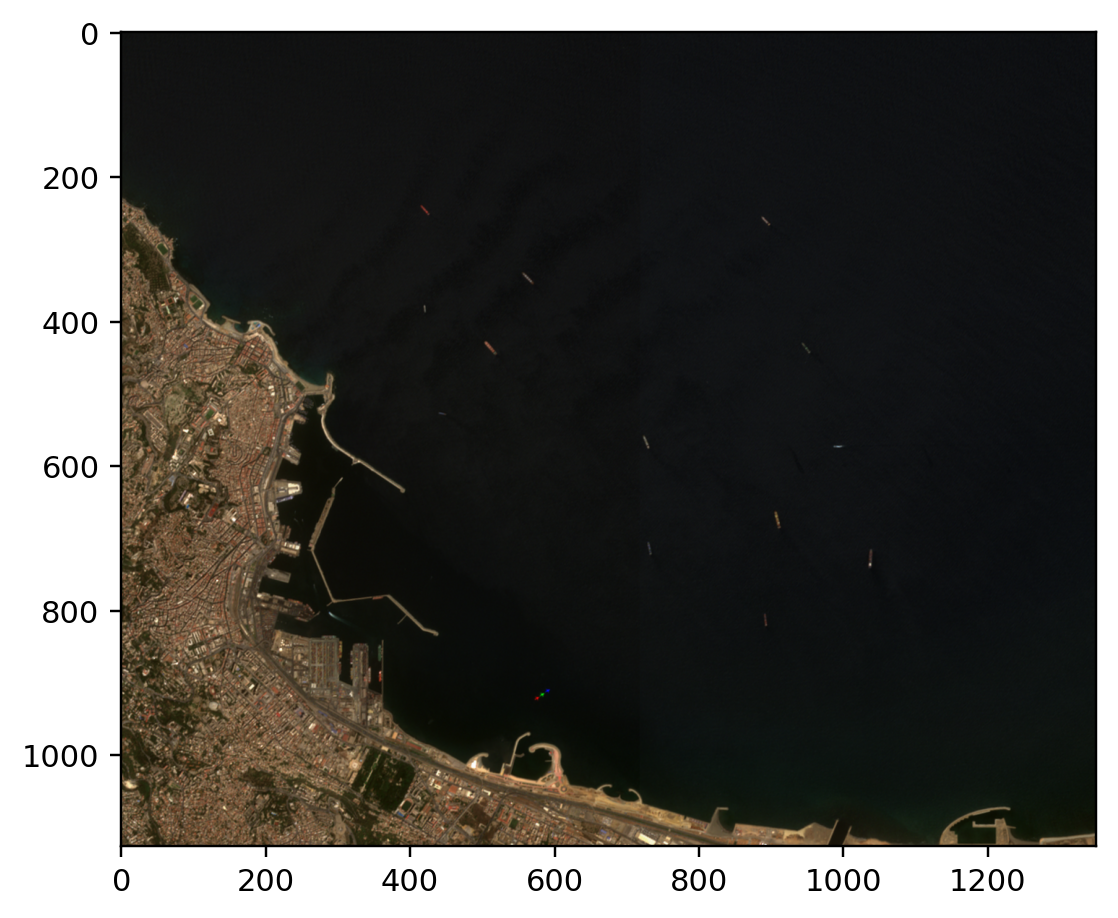

In [11]:
print('Loading file: ', path)
load = loader(results={'img_path': path})
img = load['img']



plt.figure(dpi=220)
plt.imshow(norm(img))
plt.show()


Loading file:  /home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/sen2ships/sen2ships/algiers/algiers_rgb.tiff


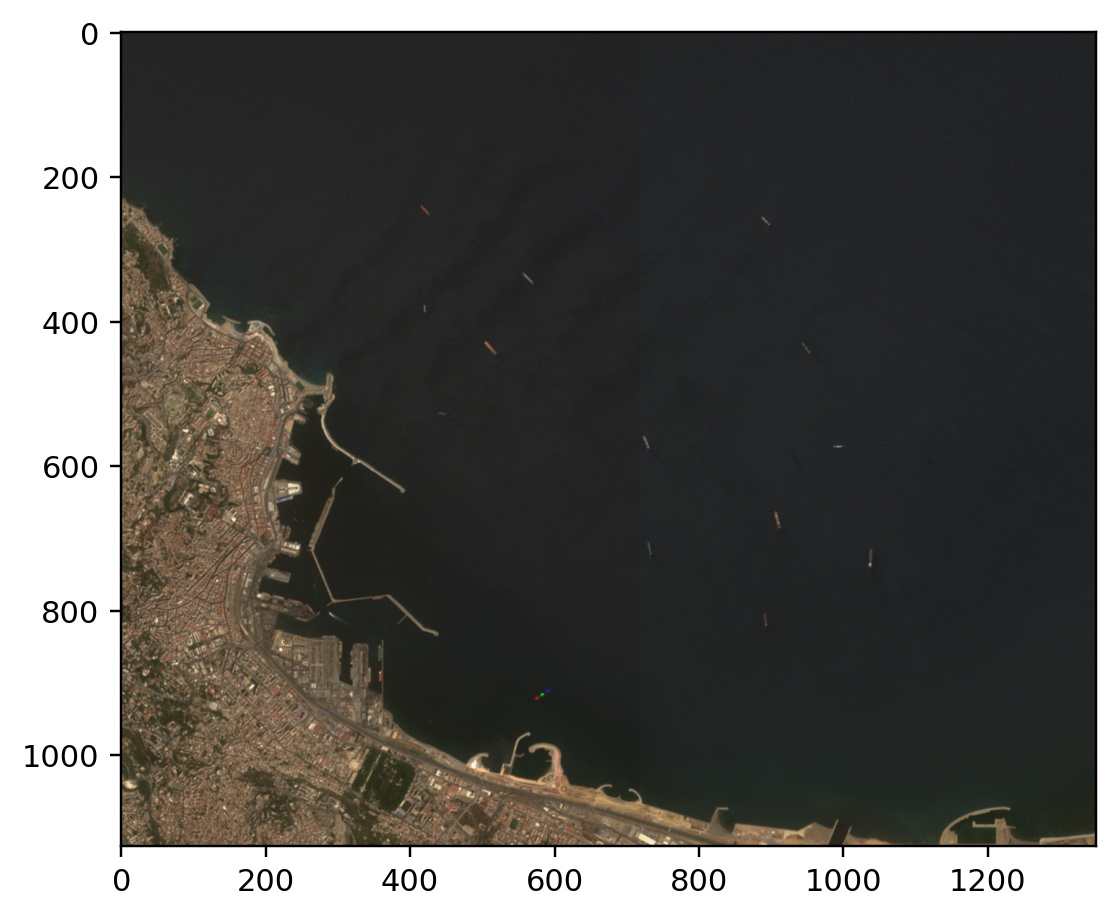

In [12]:
loader = LoadImageFromFile(to_float32=False, color_type='color', imdecode_backend='pillow', backend_args=None)

print('Loading file: ', path)
load = loader(results={'img_path': path})
img = load['img']



plt.figure(dpi=220)
plt.imshow(img[:,:,::-1])
plt.show()


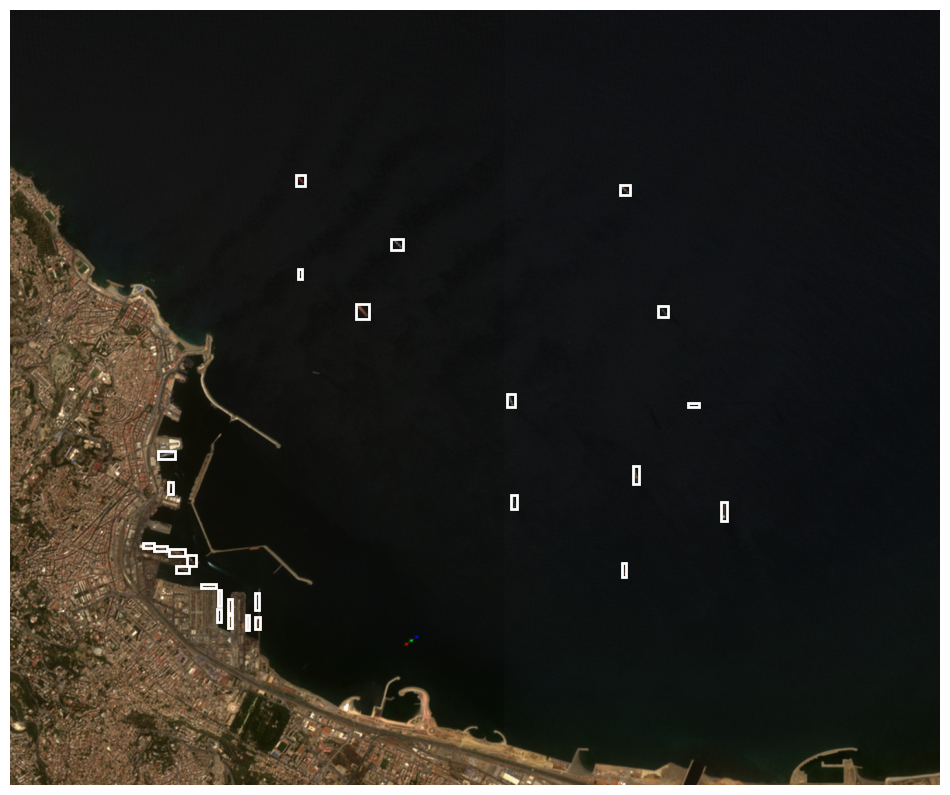

In [14]:
# show figure with gt_boxes:
draw_bounding_boxes(norm(img[:,:,::-1]), gt_boxes=gt_boxes, backend_args={'figsize': (12, 12)})

In [15]:
img.shape

(1126, 1351, 3)

In [16]:
means_red, means_green, means_blue = [], [], []
deviations_red, deviations_green, deviations_blue = [], [], []

for i in range(len(imgs)):
    path = find_full_path(file_names[i], imgs_full_path)
    load = loader(results={'img_path': path})
    img = load['img']
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    means_red.append(np.mean(r))
    means_green.append(np.mean(g))
    means_blue.append(np.mean(b))
    deviations_red.append(np.std(r))
    deviations_green.append(np.std(g))
    deviations_blue.append(np.std(b))


In [17]:
print('Average mean red: ', np.mean(means_red))
print('Average mean green: ', np.mean(means_green))
print('Average mean blue: ', np.mean(means_blue))
print('Average std red: ', np.mean(deviations_red))
print('Average std green: ', np.mean(deviations_green))
print('Average std blue: ', np.mean(deviations_blue))

# use these values to normalize the images:
# write function norm(img) to normalize the images:
def norm(img, std: int = 3):
    """
    Normalize a 16-bit image to the range [0, 1].

    Args:
        img (np.array): A 16-bit image.

    Returns:
        np.array: The normalized image, with pixel values scaled between 0 and 1.
    """
    r,g,b = img[:,:,0], img[:,:,1], img[:,:,2]
    # normalize red:
    r = (r - np.mean(r)) / std * np.std(r)
    # normalize green:
    g = (g - np.mean(g)) / std * np.std(g)
    # normalize blue:
    b = (b - np.mean(b)) / std * np.std(b)
    return np.stack((r,g,b), axis=2)


Average mean red:  44.50340694686498
Average mean green:  50.277046085001444
Average mean blue:  48.17976006663992
Average std red:  30.5096908225642
Average std green:  34.66362532011472
Average std blue:  42.3437792801501


In [ ]:
print('Loading file: ', path)
load = loader(results={'img_path': path})
img = load['img']



plt.figure(dpi=220)
plt.imshow(norm(img))
plt.show()


In [ ]:
for idx, filename in enumerate(file_names):
    path = find_full_path(file_names[idx], imgs_full_path)
    # copy image in the folder:
    shutil.copy(path, '/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/imgs/')
